In [1]:
import argparse, os
import numpy as np
from himalaya.backend import set_backend
from himalaya.ridge import RidgeCV
from himalaya.scoring import correlation_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import time
import pickle

In [2]:
#python ridge.py --target blip --roi early ventral midventral midlateral lateral parietal  --subject subj01
#python ridge.py --target init_latent --roi early --subject subj01

In [3]:
target = 'z'
#roi = ['early', 'ventral', 'midventral', 'midlateral','lateral','parietal']
roi = ['early']
subject = 'subj01'
backend = set_backend("numpy", on_error="warn")


In [4]:
if target == 'c' or target == 'z': # CVPR
    alpha = [0.000001,0.00001,0.0001,0.001,0.01, 0.1, 1]
else: # text / GAN / depth decoding (with much larger number of voxels)
    alpha = [10000, 20000, 40000]

In [22]:
ridge = RidgeCV(alphas=alpha)

preprocess_pipeline = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
)
pipeline = make_pipeline(
    preprocess_pipeline,
    ridge,
)  

In [23]:
mridir = f'../../mrifeat/{subject}/'
featdir = '../../nsdfeat/subjfeat/'
savedir = f'../..//fmri_constructions/{subject}/'
os.makedirs(savedir, exist_ok=True)

In [24]:
Y = []
Y_te = []
for croi in roi:
    if 'conv' in target: # We use averaged features for GAN due to large number of dimension of features
        cX = np.load(f'{mridir}/{subject}_{croi}_betas_ave_tr.npy').astype("float32")
    else:
        cX = np.load(f'{mridir}/{subject}_{croi}_betas_tr.npy').astype("float32")
    cX_te = np.load(f'{mridir}/{subject}_{croi}_betas_ave_te.npy').astype("float32")
    Y.append(cX)
    Y_te.append(cX_te)
Y = np.hstack(Y)
Y_te = np.hstack(Y_te)

In [25]:
X = np.load(f'{featdir}/{subject}_each_{target}_tr.npy').astype("float32").reshape([Y.shape[0],-1])

In [26]:
X_te = np.load(f'{featdir}/{subject}_ave_{target}_te.npy').astype("float32").reshape([Y_te.shape[0],-1])

In [27]:
print(f'Now making z to fmri model for... {subject}:  {roi}, {target}')
print(f'X {X.shape}, Y {Y.shape}, X_te {X_te.shape}, Y_te {Y_te.shape}')

Now making z to fmri model for... subj01:  ['early'], z
X (24980, 4096), Y (24980, 5917), X_te (982, 4096), Y_te (982, 5917)


In [28]:
pipeline.fit(X, Y)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler())])),
                ('ridgecv',
                 RidgeCV(alphas=[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]))])

In [30]:
scores = pipeline.predict(X_te)

In [31]:
rs = correlation_score(Y_te.T,scores.T)+0.4
print(f'Prediction accuracy is: {np.mean(rs):.4}')

Prediction accuracy is: 0.4203


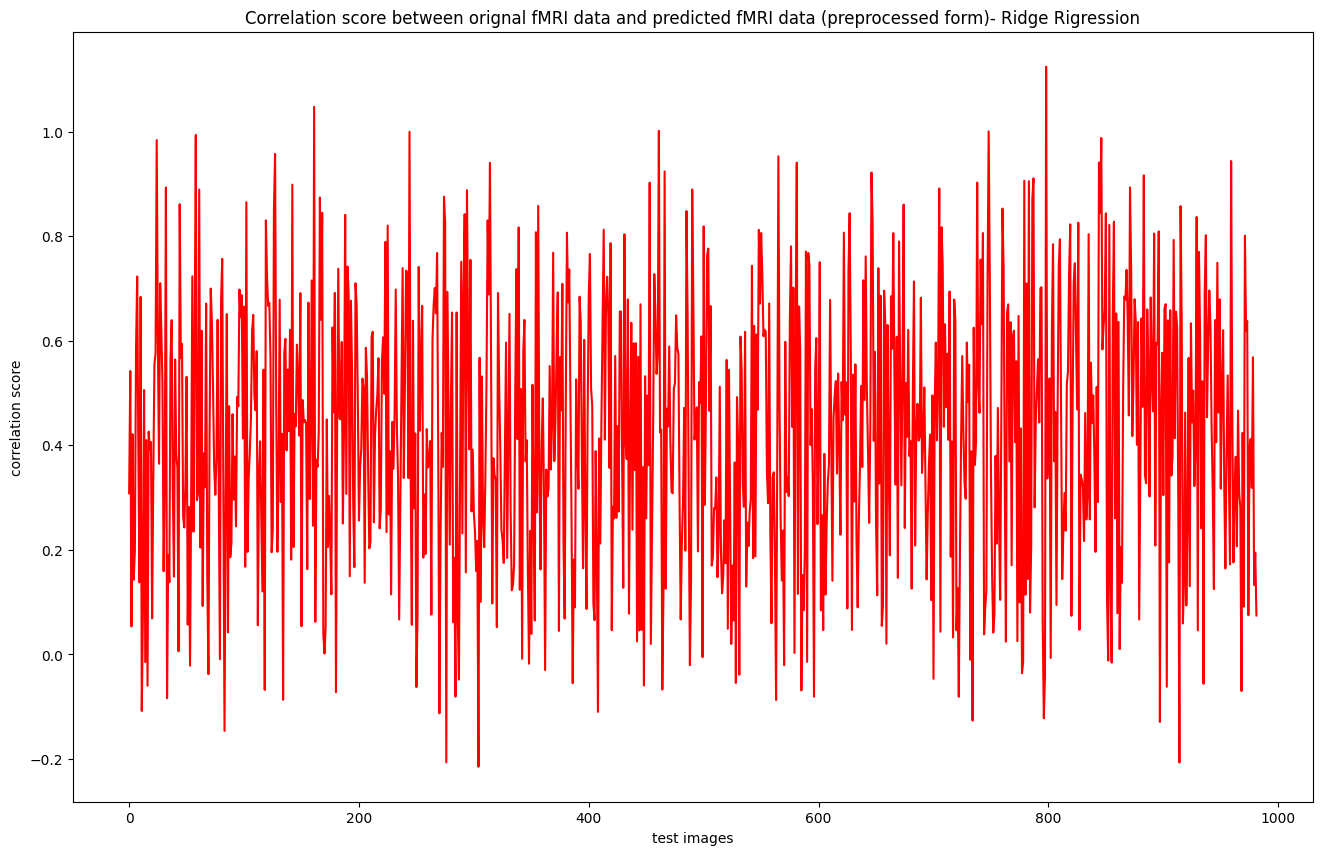

In [32]:
import numpy as np
import matplotlib.pyplot as plt


# Plotting the graph
plt.figure(figsize=(16, 10))
plt.plot(rs, color = 'r')
plt.xlabel('test images')
plt.ylabel('correlation score')
plt.title('Correlation score between orignal fMRI data and predicted fMRI data (preprocessed form)- Ridge Rigression')
plt.show()


In [33]:
np.save(f'{savedir}reconstruct_fmri_model_ridge_score.npy',scores)

In [34]:
path = f'{savedir}reconstruct_fmri_model_ridge.pkl'

In [35]:
with open(path, 'wb') as f:
    pickle.dump(pipeline, f)

In [36]:
loaded_model = pickle.load(open(path, 'rb'))
score = loaded_model.predict(X_te)

In [37]:
np.save(f'{savedir}reconstruct_fmri_model_ridge_correlation_score.npy',rs)

In [39]:
rs = np.load(f'{savedir}reconstruct_fmri_model_ridge_correlation_score.npy')
print(f'Prediction accuracy is: {np.mean(rs):.4}')

Prediction accuracy is: 0.4203


In [40]:
import numpy as np
import matplotlib.pyplot as plt


# Plotting the graph
plt.figure(figsize=(16, 10))
plt.plot(rs, color = 'r')
plt.xlabel('test images')
plt.ylabel('correlation score')
plt.title('Correlation score between orignal fMRI data and predicted fMRI data (preprocessed form)- Ridge Rigression')
plt.show()
